In [1]:
#Add necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

#For Turkish characters in the dataset
plt.rcParams['font.family'] = 'DejaVu Sans'

from google.colab import drive
drive.mount('/content/drive')

#Add the dataset and read
file_path = '/content/drive/MyDrive/DSA210_Term_Project/DSA210KişiselData.xlsx'
df = pd.read_excel(file_path)

#Check few columns
df.head()


Mounted at /content/drive


,Tarih,Uyanma Saati,Uyuma Saati,Uyuma Süresi\n(dakika),Günlük Öğün Sayısı,Ders Çalışma Süresi\n(dakika),İçilen Kahve Miktarı,Ders Adı ve Sınavının Tarihleri
0,2025-03-10,11:30:00,02:00:00,570.0,1,360,2,Math204 - 16.03.2025\nMath311 - 18.03.2025
1,2025-03-11,10:00:00,03:00:00,420.0,2,420,4,Math204 - 16.03.2025\nMath311 - 18.03.2025
2,2025-03-12,12:25:00,04:00:00,505.0,1,450,5,Math204 - 16.03.2025\nMath311 - 18.03.2025
3,2025-03-13,09:15:00,04:00:00,315.0,2,200,3,Math204 - 16.03.2025\nMath311 - 18.03.2025
4,2025-03-14,10:20:00,03:00:00,440.0,1,245,6,Math204 - 16.03.2025\nMath311 - 18.03.2025


In [2]:
#Data Correction Step Between Excel and Python

#In my dataset, I have found the sleeping time by using excel function.This part checks is there any difference between excel function and python function.
#If there is a significant difference excel function must be modified.
#If there is a rounding problem (+1 or -1) in sleeping duration, it is tolerable.
df.columns = df.columns.str.strip().str.replace('\n', ' ').str.replace(r'\s+', ' ', regex=True)
df['Uyanma Saati'] = pd.to_datetime(df['Uyanma Saati'], format='%H:%M:%S').dt.time
df['Uyuma Saati'] = pd.to_datetime(df['Uyuma Saati'], format='%H:%M:%S').dt.time

def hesapla_uyku_suresi(uyuma, uyanma):
    uyuma_dt = datetime.combine(datetime.today(), uyuma)
    uyanma_dt = datetime.combine(datetime.today(), uyanma)
    if uyanma_dt <= uyuma_dt:
        uyanma_dt += timedelta(days=1)
    return int((uyanma_dt - uyuma_dt).total_seconds() / 60)

df['Hesaplanan Uyku Süresi (dk)'] = df.apply(
    lambda row: hesapla_uyku_suresi(row['Uyuma Saati'], row['Uyanma Saati']), axis=1
)

df[['Tarih', 'Uyuma Saati', 'Uyanma Saati', 'Uyuma Süresi (dakika)', 'Hesaplanan Uyku Süresi (dk)']].head()
df['Uyuma Süresi (dakika)'] = df['Uyuma Süresi (dakika)'].astype(int)

# Compare sleep durations with a tolerance of ±1 minute
df['Sleep Duration Match?'] = abs(df['Hesaplanan Uyku Süresi (dk)'] - df['Uyuma Süresi (dakika)']) <= 1

# Check if all rows are matching within the tolerance
all_sleep_matches = df['Sleep Duration Match?'].all()

# Print result
print("Do all calculated sleep durations match the original values (within ±1 min)?:", all_sleep_matches)

# Show only mismatching rows (beyond ±1 minute)
df[~df['Sleep Duration Match?']]


Do all calculated sleep durations match the original values (within ±1 min)?: True


,Tarih,Uyanma Saati,Uyuma Saati,Uyuma Süresi (dakika),Günlük Öğün Sayısı,Ders Çalışma Süresi (dakika),İçilen Kahve Miktarı,Ders Adı ve Sınavının Tarihleri,Hesaplanan Uyku Süresi (dk),Sleep Duration Match?


In [3]:
#Data Manipulation and Enrichment Step To Use In Analysis
#Changing Raw Data Into Useful Data

# Step 1: Create a unique exam date list from the entire column
import re
all_exam_dates = set()
for raw in df['Ders Adı ve Sınavının Tarihleri'].dropna().astype(str):
    matches = re.findall(r'\d{2}\.\d{2}\.\d{4}', raw)
    for m in matches:
        try:
            all_exam_dates.add(pd.to_datetime(m, format='%d.%m.%Y'))
        except:
            pass

#Full exam dates calendar

all_exam_dates = sorted(all_exam_dates)

# Step 2: For each row, calculate all gaps from that date to each exam  (Data Manipulation)

def full_exam_gaps(row):
    today = row['Tarih']
    gaps = []
    for exam_date in all_exam_dates:
        delta = (exam_date - today).days
        if delta >= 0:
            gaps.append(delta)
    return gaps

df['All Exam Gaps'] = df.apply(full_exam_gaps, axis=1)

#If there is an exam within 7 days consider it as an active exam  (Data Enrichment)
# Step 3: Count active exams (within 7 days)
df['Active Exam Count (<=7 days)'] = df['All Exam Gaps'].apply(lambda g: sum(1 for d in g if d <= 7))


# Step 4: Calculate estimated caffeine intake from coffee count
#'İçilen Kahve Miktarı' column contains numeric values like 2, 3, 4 etc.

# Convert to numeric and calculate caffeine (75 mg per coffee) (75 mg per coffee info from Starbucks)
#1 small approximately 75 mg caffeine and 1 mid is 150 mg 1 large 225 mg.
#Since small=1 mid=2 large=3, coffee column multiplied with 75 and created new column for data enrichment

df['Estimated Caffeine Intake (mg)'] = pd.to_numeric(df['İçilen Kahve Miktarı'], errors='coerce').fillna(0).astype(int) * 75

# Optional: Preview caffeine data
df[['Tarih', 'All Exam Gaps', 'Active Exam Count (<=7 days)', 'İçilen Kahve Miktarı', 'Estimated Caffeine Intake (mg)']].head(10)


,Tarih,All Exam Gaps,Active Exam Count (<=7 days),İçilen Kahve Miktarı,Estimated Caffeine Intake (mg)
0,2025-03-10,"[6, 8, 12, 15, 34, 40, 43]",1,2,150
1,2025-03-11,"[5, 7, 11, 14, 33, 39, 42]",2,4,300
2,2025-03-12,"[4, 6, 10, 13, 32, 38, 41]",2,5,375
3,2025-03-13,"[3, 5, 9, 12, 31, 37, 40]",2,3,225
4,2025-03-14,"[2, 4, 8, 11, 30, 36, 39]",2,6,450
5,2025-03-15,"[1, 3, 7, 10, 29, 35, 38]",3,3,225
6,2025-03-16,"[0, 2, 6, 9, 28, 34, 37]",3,0,0
7,2025-03-17,"[1, 5, 8, 27, 33, 36]",2,5,375
8,2025-03-18,"[0, 4, 7, 26, 32, 35]",3,4,300
9,2025-03-19,"[3, 6, 25, 31, 34]",2,3,225


# Question 1: Does sleep duration significantly correlate with study time?

**H₀**: There is no significant correlation between sleep duration and study time.  
**H₁**: There is a significant correlation between sleep duration and study time.


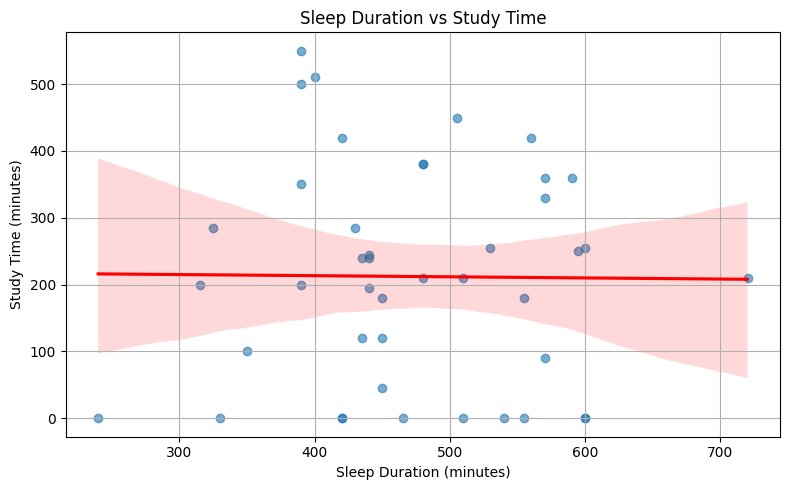

🔍 Hypothesis Test: Sleep Duration vs Study Time
H₀: No significant correlation between sleep duration and study time.
H₁: There is a significant correlation between sleep duration and study time.

Pearson Correlation: -0.010
P-value: 0.9495
❌ Fail to reject H₀ → No significant correlation.


In [ ]:
# Question 1: Does sleep duration significantly correlate with study time?

# H₀: There is no significant correlation between sleep duration and study time.
# H₁: There is a significant correlation between sleep duration and study time.

from scipy.stats import pearsonr
import seaborn as sns
import matplotlib.pyplot as plt

# Define variables
sleep = df['Hesaplanan Uyku Süresi (dk)']
study = df['Ders Çalışma Süresi (dakika)']

# Perform Pearson correlation test
corr_val, p_val = pearsonr(sleep, study)

# Visualization: Scatter plot with regression line
plt.figure(figsize=(8, 5))
sns.regplot(x=sleep, y=study, line_kws={'color': 'red'}, scatter_kws={'alpha': 0.6})
plt.title("Sleep Duration vs Study Time")
plt.xlabel("Sleep Duration (minutes)")
plt.ylabel("Study Time (minutes)")
plt.grid(True)
plt.tight_layout()
plt.show()

# Print correlation result
print("🔍 Hypothesis Test: Sleep Duration vs Study Time")
print("H₀: No significant correlation between sleep duration and study time.")
print("H₁: There is a significant correlation between sleep duration and study time.")
print(f"\nPearson Correlation: {corr_val:.3f}")
print(f"P-value: {p_val:.4f}")

# Decision based on alpha = 0.05
if p_val < 0.05:
    print("✅ Reject H₀ → There is a significant correlation.")
else:
    print("❌ Fail to reject H₀ → No significant correlation.")


# Question 2: Does number of exams in 7 days affect sleep duration?

**H₀**: There is no significant difference in average sleep duration between students with 0, 1, or 2+ upcoming exams.  
**H₁**: At least one group differs significantly in average sleep duration.


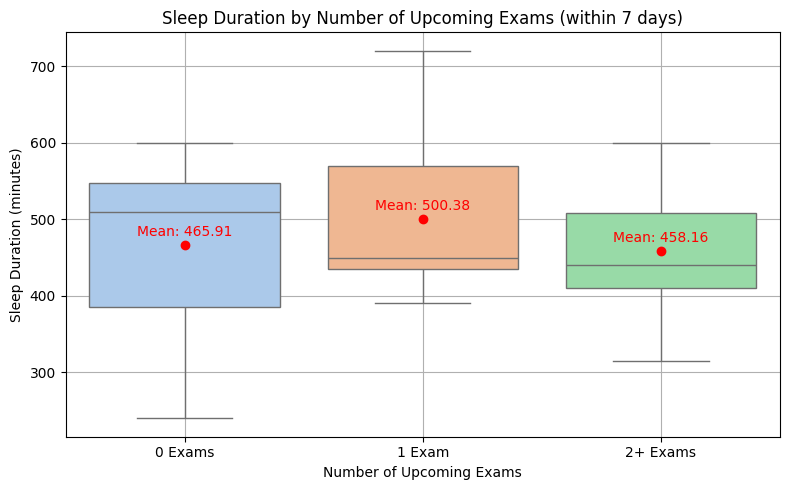

🔍 Hypothesis Test: Sleep Duration vs Number of Upcoming Exams
H₀: No significant difference in sleep duration between groups (0, 1, 2+ exams).
H₁: At least one group differs significantly.

F-statistic: 0.779
P-value: 0.4658
❌ Fail to reject H₀ → No significant difference in sleep duration.


In [ ]:
#Question 2:Does number of exams in 7 days affect sleep duration?

# H₀: There is no significant difference in average sleep duration between students with 0, 1, or 2+ upcoming exams.
# H₁: At least one group differs significantly in average sleep duration.

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import f_oneway

# Step 1: Label the exam pressure levels as 0 / 1 / 2+
def label_exam_group(count):
    if count == 0:
        return "0 Exams"
    elif count == 1:
        return "1 Exam"
    else:
        return "2+ Exams"

df['Exam Pressure Group'] = df['Active Exam Count (<=7 days)'].apply(label_exam_group)

# 🔧 Force category order for consistent plotting
df['Exam Pressure Group'] = pd.Categorical(
    df['Exam Pressure Group'],
    categories=["0 Exams", "1 Exam", "2+ Exams"],
    ordered=True
)

# Step 2: Calculate group means to show on the plot
group_means = df.groupby('Exam Pressure Group', observed=True)['Hesaplanan Uyku Süresi (dk)'].mean().round(2)
group_means = group_means.reindex(["0 Exams", "1 Exam", "2+ Exams"])

# Step 3: Plot the boxplot with group means as points
plt.figure(figsize=(8, 5))

# Boxplot (Warning-free)
sns.boxplot(
    data=df,
    x='Exam Pressure Group',
    y='Hesaplanan Uyku Süresi (dk)',
    hue='Exam Pressure Group',
    palette="pastel",
    legend=False
)

# Pointplot (Warning-free)
sns.pointplot(
    data=df,
    x='Exam Pressure Group',
    y='Hesaplanan Uyku Süresi (dk)',
    estimator='mean',
    color='red',
    linestyles="",
    errorbar=None,
    markers="o",
    markersize=5
)

# Annotate the means on the graph
for i, (group, mean) in enumerate(group_means.items()):
    plt.text(i, mean + 12, f"Mean: {mean}", ha='center', color='red', fontsize=10)

plt.title("Sleep Duration by Number of Upcoming Exams (within 7 days)")
plt.xlabel("Number of Upcoming Exams")
plt.ylabel("Sleep Duration (minutes)")
plt.grid(True)
plt.tight_layout()
plt.show()

# Step 4: Hypothesis Test (One-Way ANOVA)

# H₀: There is no significant difference in average sleep duration between students with 0, 1, or 2+ upcoming exams.
# H₁: At least one group differs significantly in average sleep duration.

# Define the groups for ANOVA test
group_0 = df[df['Active Exam Count (<=7 days)'] == 0]['Hesaplanan Uyku Süresi (dk)']
group_1 = df[df['Active Exam Count (<=7 days)'] == 1]['Hesaplanan Uyku Süresi (dk)']
group_2plus = df[df['Active Exam Count (<=7 days)'] >= 2]['Hesaplanan Uyku Süresi (dk)']

# Perform ANOVA
f_stat, p_val = f_oneway(group_0, group_1, group_2plus)

# Print results
print("🔍 Hypothesis Test: Sleep Duration vs Number of Upcoming Exams")
print("H₀: No significant difference in sleep duration between groups (0, 1, 2+ exams).")
print("H₁: At least one group differs significantly.")
print(f"\nF-statistic: {f_stat:.3f}")
print(f"P-value: {p_val:.4f}")

if p_val < 0.05:
    print("✅ Reject H₀ → Number of upcoming exams significantly affects sleep duration.")
else:
    print("❌ Fail to reject H₀ → No significant difference in sleep duration.")



# Question 3: Does the number of upcoming exams affect eating habits?

**H₀**: There is no significant difference in the number of meals among students with 0, 1, or 2+ upcoming exams.  
**H₁**: At least one group differs significantly in the number of meals.


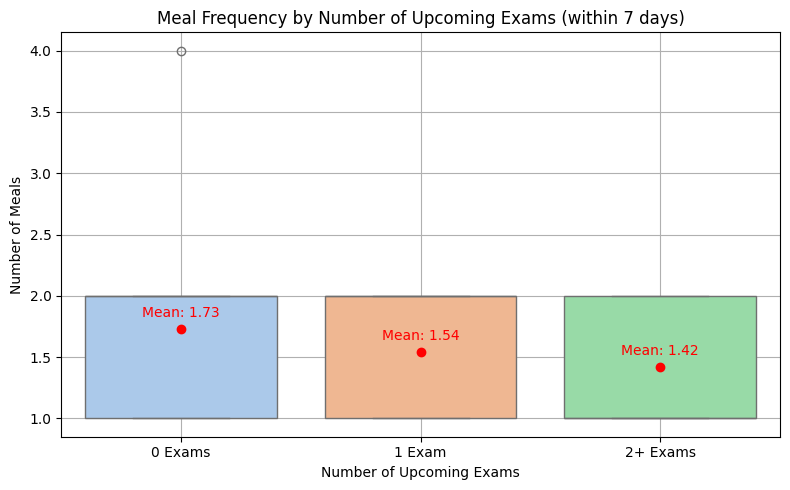

🔍 Hypothesis Test: Number of Meals vs Number of Upcoming Exams
H₀: There is no significant difference in number of meals across groups.
H₁: At least one group differs significantly.

F-statistic: 0.815
P-value: 0.4500
❌ Fail to reject H₀ → No significant difference in eating habits between groups.


In [ ]:
# Question 3: Does the number of upcoming exams affect eating habits?

# H₀: There is no significant difference in the number of meals among students with 0, 1, or 2+ upcoming exams.
# H₁: At least one group differs significantly in the number of meals.

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import f_oneway

# Step 1: Create group labels for plotting
def exam_group_label(x):
    if x == 0:
        return "0 Exams"
    elif x == 1:
        return "1 Exam"
    else:
        return "2+ Exams"

df['Exam Group'] = df['Active Exam Count (<=7 days)'].apply(exam_group_label)

# Categorize for proper ordering
df['Exam Group'] = pd.Categorical(
    df['Exam Group'],
    categories=["0 Exams", "1 Exam", "2+ Exams"],
    ordered=True
)

# Step 2: Calculate group means
group_means = df.groupby('Exam Group', observed=True)['Günlük Öğün Sayısı'].mean().round(2)
group_means = group_means.reindex(["0 Exams", "1 Exam", "2+ Exams"])

# Step 3: Boxplot with group means
plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x='Exam Group', y='Günlük Öğün Sayısı', hue='Exam Group', palette='pastel', legend=False)

# 🔴 Only mean points (no error bars or lines)
sns.pointplot(
    data=df,
    x='Exam Group',
    y='Günlük Öğün Sayısı',
    estimator='mean',
    color='red',
    linestyles="",
    errorbar=None,
    markers="o",
    markersize=5
)

# Annotate group means on the plot
for i, (group, mean) in enumerate(group_means.items()):
    plt.text(i, mean + 0.1, f"Mean: {mean}", ha='center', color='red', fontsize=10)

plt.title("Meal Frequency by Number of Upcoming Exams (within 7 days)")
plt.xlabel("Number of Upcoming Exams")
plt.ylabel("Number of Meals")
plt.grid(True)
plt.tight_layout()
plt.show()

# Step 4: Hypothesis Testing (ANOVA)

# Define exam count groups
group_0 = df[df['Active Exam Count (<=7 days)'] == 0]['Günlük Öğün Sayısı']
group_1 = df[df['Active Exam Count (<=7 days)'] == 1]['Günlük Öğün Sayısı']
group_2plus = df[df['Active Exam Count (<=7 days)'] >= 2]['Günlük Öğün Sayısı']

# Apply ANOVA
f_stat, p_val = f_oneway(group_0, group_1, group_2plus)

# Display test results
print("🔍 Hypothesis Test: Number of Meals vs Number of Upcoming Exams")
print("H₀: There is no significant difference in number of meals across groups.")
print("H₁: At least one group differs significantly.")
print(f"\nF-statistic: {f_stat:.3f}")
print(f"P-value: {p_val:.4f}")

if p_val < 0.05:
    print("✅ Reject H₀ → Number of upcoming exams significantly affects eating habits.")
else:
    print("❌ Fail to reject H₀ → No significant difference in eating habits between groups.")


# Question 4: Does caffeine intake significantly change depending on number of upcoming exams?

**H₀**: There is no significant correlation between number of upcoming exams and caffeine intake.  
**H₁**: There is a significant correlation between number of upcoming exams and caffeine intake.  


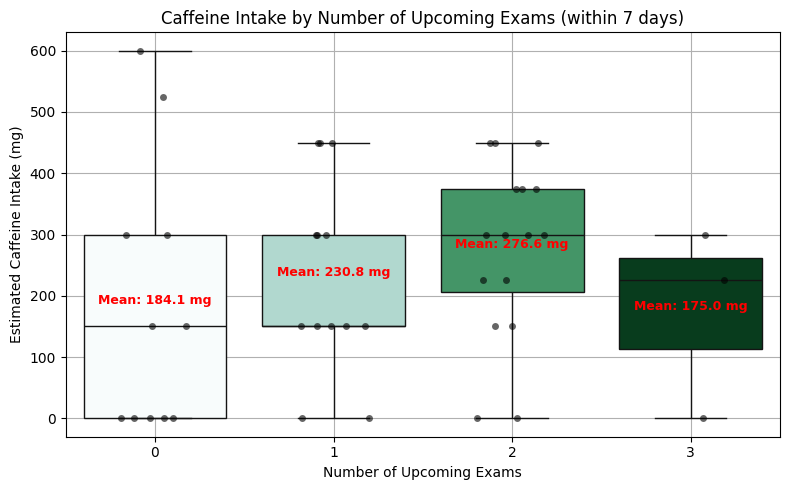


📈 Descriptive Stats (Caffeine Intake by Exam Count):

                                mean  median
Active Exam Count (<=7 days)                
0                             184.09   150.0
1                             230.77   150.0
2                             276.56   300.0
3                             175.00   225.0

🔬 Hypothesis Test: Caffeine Intake vs Number of Upcoming Exams
H₀: There is no significant correlation between number of upcoming exams and caffeine intake.
H₁: There is a significant correlation.

Pearson Correlation: 0.136
P-value: 0.3860
❌ Fail to reject H₀ → No significant relationship.


In [ ]:
from scipy.stats import pearsonr
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Drop rows with missing values in required columns
df_filtered = df.dropna(subset=['Active Exam Count (<=7 days)', 'Estimated Caffeine Intake (mg)'])

# Extract variables
x_exam_count = df_filtered['Active Exam Count (<=7 days)']
y_caffeine = df_filtered['Estimated Caffeine Intake (mg)']

# Pearson correlation
corr_caffeine, p_caffeine = pearsonr(x_exam_count, y_caffeine)

# ---------------------------
# 📊 Graph Visualization
# ---------------------------
plt.figure(figsize=(8, 5))
sns.boxplot(data=df_filtered,
            x='Active Exam Count (<=7 days)',
            y='Estimated Caffeine Intake (mg)',
            hue='Active Exam Count (<=7 days)',
            palette='BuGn', dodge=False, legend=False)
sns.stripplot(data=df_filtered,
              x='Active Exam Count (<=7 days)',
              y='Estimated Caffeine Intake (mg)',
              color='black', alpha=0.6, jitter=0.2)

# Add red mean labels
group_stats = df_filtered.groupby('Active Exam Count (<=7 days)')['Estimated Caffeine Intake (mg)'].agg(['mean', 'median'])
for i, mean in enumerate(group_stats['mean']):
    plt.text(i, mean + 2, f"Mean: {mean:.1f} mg", color='red', ha='center', fontsize=9, fontweight='bold')

plt.title("Caffeine Intake by Number of Upcoming Exams (within 7 days)")
plt.xlabel("Number of Upcoming Exams")
plt.ylabel("Estimated Caffeine Intake (mg)")
plt.grid(True)
plt.tight_layout()
plt.show()

# ---------------------------
# 📈 Descriptive Statistics
# ---------------------------
print("\n📈 Descriptive Stats (Caffeine Intake by Exam Count):\n")
print(group_stats.round(2))

# ---------------------------
# 🧪 Hypothesis Test
# ---------------------------
print("\n🔬 Hypothesis Test: Caffeine Intake vs Number of Upcoming Exams")
print("H₀: There is no significant correlation between number of upcoming exams and caffeine intake.")
print("H₁: There is a significant correlation.\n")

# ---------------------------
# ✅ Test Result
# ---------------------------
print(f"Pearson Correlation: {corr_caffeine:.3f}")
print(f"P-value: {p_caffeine:.4f}")

if p_caffeine < 0.05:
    print("✅ Reject H₀ → Number of upcoming exams significantly affects caffeine intake.")
else:
    print("❌ Fail to reject H₀ → No significant relationship.")


# Question 5: How much is the change in the studying hour depending on the active exams (within 7 days)?

**H₀**: There is no significant difference in average study time across groups.  
**H₁**: At least one group differs significantly.


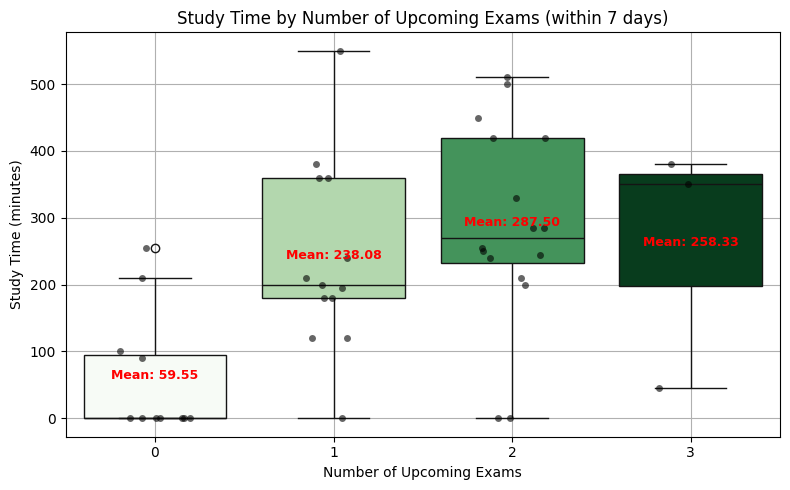


📈 Descriptive Stats (Study Time by Exam Count):

                                mean  median
Active Exam Count (<=7 days)                
0                              59.55     0.0
1                             238.08   200.0
2                             287.50   270.0
3                             258.33   350.0

🔬 Hypothesis Test: Study Time vs Number of Upcoming Exams
H₀: There is no significant difference in average study time across groups.
H₁: At least one group differs significantly.

F-statistic: 9.662
P-value: 0.0004
✅ Reject H₀ → Number of upcoming exams significantly affects study time.


In [ ]:
#Question 5: How much is the change is the studying hour depending on the active exams (within 7 days)?

from scipy.stats import f_oneway
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Drop missing values
df_filtered = df.dropna(subset=['Active Exam Count (<=7 days)', 'Ders Çalışma Süresi (dakika)'])

# Grouped descriptive stats
group_stats = df_filtered.groupby('Active Exam Count (<=7 days)')['Ders Çalışma Süresi (dakika)'].agg(['mean', 'median'])

# ---------------------------
# 📊 Graph Visualization
# ---------------------------
plt.figure(figsize=(8, 5))
sns.boxplot(data=df_filtered,
            x='Active Exam Count (<=7 days)',
            y='Ders Çalışma Süresi (dakika)',
            hue='Active Exam Count (<=7 days)',
            palette='Greens', dodge=False, legend=False)
sns.stripplot(data=df_filtered,
              x='Active Exam Count (<=7 days)',
              y='Ders Çalışma Süresi (dakika)',
              color='black', alpha=0.6, jitter=0.2)

# Annotate mean values in red
for i, mean in enumerate(group_stats['mean']):
    plt.text(i, mean + 0.0000017, f"Mean: {mean:.2f}", color='red', ha='center', fontsize=9, fontweight='bold')

plt.title("Study Time by Number of Upcoming Exams (within 7 days)")
plt.xlabel("Number of Upcoming Exams")
plt.ylabel("Study Time (minutes)")
plt.grid(True)
plt.tight_layout()
plt.show()

# ---------------------------
# 📈 Descriptive Statistics
# ---------------------------
print("\n📈 Descriptive Stats (Study Time by Exam Count):\n")
print(group_stats.round(2))

# ---------------------------
# 🔬 Hypothesis Test
# ---------------------------
print("\n🔬 Hypothesis Test: Study Time vs Number of Upcoming Exams")
print("H₀: There is no significant difference in average study time across groups.")
print("H₁: At least one group differs significantly.\n")

# Perform ANOVA test
group_0 = df_filtered[df_filtered['Active Exam Count (<=7 days)'] == 0]['Ders Çalışma Süresi (dakika)']
group_1 = df_filtered[df_filtered['Active Exam Count (<=7 days)'] == 1]['Ders Çalışma Süresi (dakika)']
group_2plus = df_filtered[df_filtered['Active Exam Count (<=7 days)'] >= 2]['Ders Çalışma Süresi (dakika)']

f_stat, p_val = f_oneway(group_0, group_1, group_2plus)

# ---------------------------
# ✅ Test Result
# ---------------------------
print(f"F-statistic: {f_stat:.3f}")
print(f"P-value: {p_val:.4f}")

if p_val < 0.05:
    print("✅ Reject H₀ → Number of upcoming exams significantly affects study time.")
else:
    print("❌ Fail to reject H₀ → No significant difference in study time between groups.")


# Question 6: Which exam affects studying hours most (based on average daily study hours)?

This question is answered by comparing the **average daily study time** associated with each exam (excluding exam days).

📊 Study Distribution per Nearest Upcoming Exam (excluding exam day):

CS204 (2025-03-22):
  → Total Study Hours: 26.67 hrs
  → Days Counted: 4 days
  → Average Daily Study: 6.67 hrs/day

DSA210 (2025-04-13):
  → Total Study Hours: 25.00 hrs
  → Days Counted: 7 days
  → Average Daily Study: 3.57 hrs/day

HUM207 (2025-03-25):
  → Total Study Hours: 3.00 hrs
  → Days Counted: 3 days
  → Average Daily Study: 1.00 hrs/day

MATH306 (2025-04-19):
  → Total Study Hours: 24.75 hrs
  → Days Counted: 6 days
  → Average Daily Study: 4.12 hrs/day

MATH311 (2025-04-22):
  → Total Study Hours: 19.00 hrs
  → Days Counted: 3 days
  → Average Daily Study: 6.33 hrs/day

Math204 (2025-03-16):
  → Total Study Hours: 34.25 hrs
  → Days Counted: 6 days
  → Average Daily Study: 5.71 hrs/day

Math311 (2025-03-18):
  → Total Study Hours: 5.50 hrs
  → Days Counted: 2 days
  → Average Daily Study: 2.75 hrs/day



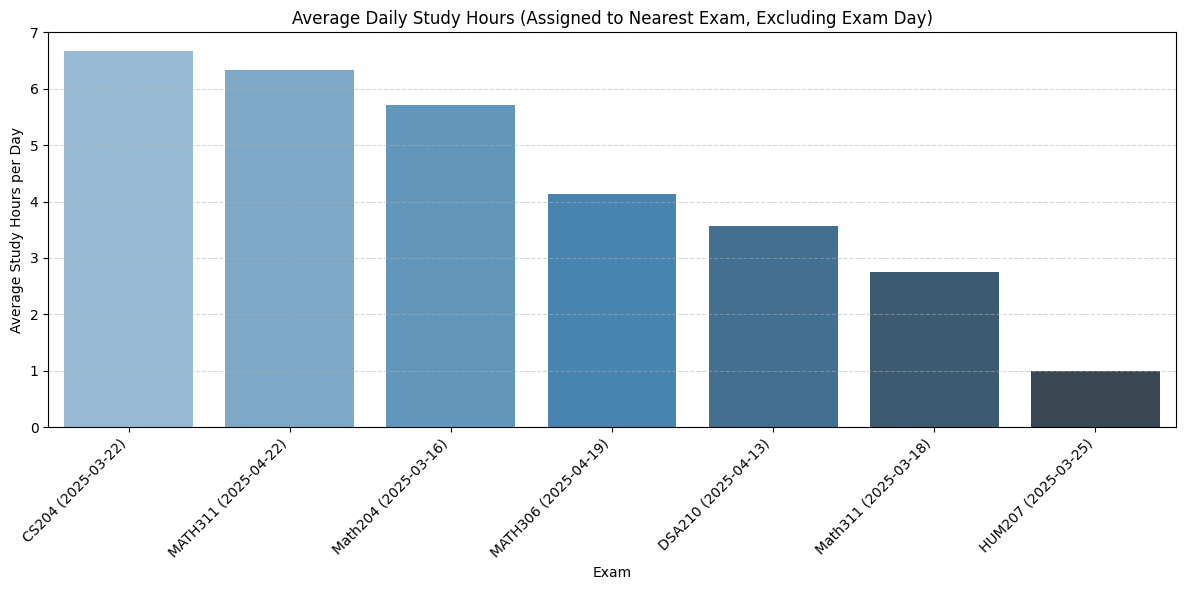

🎯 Top 3 Exams with Highest Average Daily Study:

CS204 (2025-03-22):
  → Average Daily Study: 6.67 hrs/day

MATH311 (2025-04-22):
  → Average Daily Study: 6.33 hrs/day

Math204 (2025-03-16):
  → Average Daily Study: 5.71 hrs/day



In [ ]:
# Question 6: Which exam affect studying hours most?

# Rebuild the analysis based on these rules:
# - Each study session is assigned to the closest exam (within 7 days), but NOT ON the exam day
# - Study assigned to the closest exam otherwise exam time conflicts (more than 1 exam in 7 days) can cause analysis problems
# - Study data on an exam day is excluded for that exam
# - If a study day is the exam day for one course, it's not counted for that course

# Most affected 3 exams (based on average daily study) are printed

import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_excel("/content/drive/MyDrive/DSA210_Term_Project/DSA210KişiselData.xlsx")

# Normalize column names
df.columns = df.columns.str.strip().str.replace('\n', ' ').str.replace(r'\s+', ' ', regex=True)

# Step 1: Extract all unique exam name-date pairs from the exam column
exam_infos = []
for raw in df['Ders Adı ve Sınavının Tarihleri'].dropna().astype(str):
    matches = re.findall(r'(.*?)\s*-\s*(\d{2}\.\d{2}\.\d{4})', raw)
    for name, date_str in matches:
        try:
            exam_infos.append({
                'Exam Name': name.strip(),
                'Exam Date': pd.to_datetime(date_str, format='%d.%m.%Y')
            })
        except:
            continue

exam_df = pd.DataFrame(exam_infos).drop_duplicates()

# Step 2: Assign each study session to the closest exam (within 7 days, excluding exam day itself)
study_assignments = []

for idx, row in df.iterrows():
    study_date = row['Tarih']
    study_minutes = row['Ders Çalışma Süresi (dakika)']
    if pd.isna(study_date) or pd.isna(study_minutes):
        continue

    future_exams = exam_df[
        (exam_df['Exam Date'] > study_date) &
        (exam_df['Exam Date'] <= study_date + pd.Timedelta(days=7))
    ]

    if future_exams.empty:
        continue

    future_exams = future_exams.copy()
    future_exams['Gap'] = (future_exams['Exam Date'] - study_date).dt.days
    closest_exam = future_exams.sort_values('Gap').iloc[0]

    study_assignments.append({
        'Study Date': study_date,
        'Study Duration (hours)': float(study_minutes) / 60,
        'Exam Name': closest_exam['Exam Name'],
        'Exam Date': closest_exam['Exam Date']
    })

# Step 3: Create DataFrame from assignments
assigned_df = pd.DataFrame(study_assignments)

# Step 4: Aggregate per exam
exam_study_summary = assigned_df.groupby(['Exam Name', 'Exam Date']).agg(
    Total_Hours=('Study Duration (hours)', 'sum'),
    Days_Count=('Study Date', 'nunique'),
    Avg_Hours=('Study Duration (hours)', 'mean')
).reset_index()

# Step 5: Print summary
print("📊 Study Distribution per Nearest Upcoming Exam (excluding exam day):\n")
for _, row in exam_study_summary.iterrows():
    print(f"{row['Exam Name']} ({row['Exam Date'].date()}):")
    print(f"  → Total Study Hours: {row['Total_Hours']:.2f} hrs")
    print(f"  → Days Counted: {int(row['Days_Count'])} days")
    print(f"  → Average Daily Study: {row['Avg_Hours']:.2f} hrs/day\n")

# Step 6: Visualization of Average Daily Study Hours
sorted_df = exam_study_summary.sort_values(by='Avg_Hours', ascending=False)
sorted_df['Exam Label'] = sorted_df['Exam Name'] + " (" + sorted_df['Exam Date'].dt.strftime('%Y-%m-%d') + ")"

plt.figure(figsize=(12, 6))
sns.barplot(
    data=sorted_df,
    x='Exam Label',
    y='Avg_Hours',
    hue='Exam Label',
    palette='Blues_d',
    legend=False
)

plt.title("Average Daily Study Hours (Assigned to Nearest Exam, Excluding Exam Day)")
plt.xlabel("Exam")
plt.ylabel("Average Study Hours per Day")
plt.xticks(rotation=45, ha='right')
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Step 7: Print Top 3 Exams
top3 = sorted_df.sort_values(by='Avg_Hours', ascending=False).head(3)
print("🎯 Top 3 Exams with Highest Average Daily Study:\n")
for _, row in top3.iterrows():
    print(f"{row['Exam Name']} ({row['Exam Date'].date()}):")
    print(f"  → Average Daily Study: {row['Avg_Hours']:.2f} hrs/day\n")

# Supervised Learning: Regression Model


**Algorithm:**Random Forest Generator


**Aim:**Predict Study Hour



In [15]:
#Supervised Learning:Regression Model

#Ensemble Learning Random Forest Regressor Algorithm

# 📦 Import Required Libraries
import pandas as pd
import numpy as np
import re
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# 🧹 Clean and normalize column names
df.columns = df.columns.str.strip().str.replace('\n', ' ').str.replace(r'\s+', ' ', regex=True)

# 🧠 Helper function: convert time (HH:MM:SS) to total minutes since midnight
def time_to_minutes(t):
    return t.hour * 60 + t.minute

# 📊 Compute caffeine intake (assume 75 mg per coffee)
df['Estimated Caffeine Intake (mg)'] = pd.to_numeric(df['İçilen Kahve Miktarı'], errors='coerce').fillna(0).astype(int) * 75

# 📅 Extract exam dates from text
exam_dates = set()
for entry in df['Ders Adı ve Sınavının Tarihleri'].dropna().astype(str):
    matches = re.findall(r'\d{2}\.\d{2}\.\d{4}', entry)
    for date_str in matches:
        try:
            exam_dates.add(pd.to_datetime(date_str, format='%d.%m.%Y'))
        except:
            continue
exam_dates = sorted(exam_dates)

# 🔁 Calculate days until each exam
def compute_exam_gaps(row):
    today = row['Tarih']
    gaps = [(exam - today).days for exam in exam_dates if (exam - today).days >= 0]
    return gaps

df['All Exam Gaps'] = df.apply(compute_exam_gaps, axis=1)
df['Min Exam Gap'] = df['All Exam Gaps'].apply(lambda x: min(x) if len(x) > 0 else 999)
df['Active Exam Count (<=7 days)'] = df['All Exam Gaps'].apply(lambda x: sum(1 for d in x if d <= 7))

# ⏰ Convert sleep/wake time to numeric
df['Sleep Time (min)'] = df['Uyuma Saati'].apply(time_to_minutes)
df['Wake Time (min)'] = df['Uyanma Saati'].apply(time_to_minutes)

# 🎯 Ensure the target column is numeric
df['Ders Çalışma Süresi (dakika)'] = pd.to_numeric(df['Ders Çalışma Süresi (dakika)'], errors='coerce')

# 📥 Define features and target
features = [
    'Uyuma Süresi (dakika)',                    # Sleep duration
    'Estimated Caffeine Intake (mg)',           # Caffeine
    'Günlük Öğün Sayısı',                       # Meal count
    'Active Exam Count (<=7 days)',             # Exams within 7 days
    'Min Exam Gap',                             # Days to next exam
    'Sleep Time (min)',                         # Bedtime
    'Wake Time (min)'                           # Wake time
]
target = 'Ders Çalışma Süresi (dakika)'

X = df[features]
y = df[target]

# 🔀 Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 🌳 Train Random Forest
rfg_default_model = RandomForestRegressor(random_state=42)
rfg_default_model.fit(X_train, y_train)

# 📈 Evaluate model
y_pred_rfg_default = rfg_default_model.predict(X_test)
r2_rfg_default = r2_score(y_test, y_pred_rfg_default)
rmse_rfg_default = np.sqrt(mean_squared_error(y_test, y_pred_rfg_default))

# 📊 Print results
print("R² Score:", round(r2_rfg_default, 3))
print("RMSE:", round(rmse_rfg_default, 2), "minutes")


R² Score: 0.659
RMSE: 83.36 minutes


In [13]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Updated parameter grid (replaced 'auto' with None)
param_grid = [
    {'n_estimators': 100, 'max_depth': None, 'max_features': None, 'min_samples_split': 2},
    {'n_estimators': 100, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_split': 2},
    {'n_estimators': 150, 'max_depth': 15, 'max_features': 'log2', 'min_samples_split': 4},
    {'n_estimators': 200, 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_split': 5},
    {'n_estimators': 250, 'max_depth': 25, 'max_features': None, 'min_samples_split': 10},
    {'n_estimators': 300, 'max_depth': 30, 'max_features': 'log2', 'min_samples_split': 2},
    {'n_estimators': 300, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_split': 5},
    {'n_estimators': 500, 'max_depth': 20, 'max_features': None, 'min_samples_split': 2},
    {'n_estimators': 500, 'max_depth': None, 'max_features': 'log2', 'min_samples_split': 10}
]

print("🔍 Random Forest Extended Hyperparameter Tuning Results:\n")

for params in param_grid:
    rf = RandomForestRegressor(
        n_estimators=params['n_estimators'],
        max_depth=params['max_depth'],
        max_features=params['max_features'],
        min_samples_split=params['min_samples_split'],
        random_state=42
    )
    rf.fit(X_train, y_train)
    preds = rf.predict(X_test)

    r2 = r2_score(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))

    print(f"n_estimators = {params['n_estimators']}, max_depth = {params['max_depth']}, "
          f"max_features = {params['max_features']}, min_samples_split = {params['min_samples_split']}")
    print(f"→ R² Score: {r2:.3f}, RMSE: {rmse:.2f} minutes\n")



🔍 Random Forest Extended Hyperparameter Tuning Results:

n_estimators = 100, max_depth = None, max_features = None, min_samples_split = 2
→ R² Score: 0.659, RMSE: 83.36 minutes

n_estimators = 100, max_depth = 10, max_features = sqrt, min_samples_split = 2
→ R² Score: 0.635, RMSE: 86.31 minutes

n_estimators = 150, max_depth = 15, max_features = log2, min_samples_split = 4
→ R² Score: 0.569, RMSE: 93.72 minutes

n_estimators = 200, max_depth = 20, max_features = sqrt, min_samples_split = 5
→ R² Score: 0.567, RMSE: 94.00 minutes

n_estimators = 250, max_depth = 25, max_features = None, min_samples_split = 10
→ R² Score: 0.599, RMSE: 90.40 minutes

n_estimators = 300, max_depth = 30, max_features = log2, min_samples_split = 2
→ R² Score: 0.605, RMSE: 89.76 minutes

n_estimators = 300, max_depth = None, max_features = sqrt, min_samples_split = 5
→ R² Score: 0.570, RMSE: 93.65 minutes

n_estimators = 500, max_depth = 20, max_features = None, min_samples_split = 2
→ R² Score: 0.649, RMSE: 8


### 📊 Random Forest Hyperparameter Tuning Summary

**n_estimators = 100, max_depth = None, max_features = None, min_samples_split = 2**  
→ R² Score: 0.659  
→ RMSE: 83.36 minutes  
✅ This configuration gave the best overall performance.

**n_estimators = 100, max_depth = 10, max_features = sqrt, min_samples_split = 2**  
→ R² Score: 0.635  
→ RMSE: 86.31 minutes  
Slight performance drop compared to the default configuration.

**n_estimators = 200, max_depth = 20, max_features = sqrt, min_samples_split = 5**  
→ R² Score: 0.567  
→ RMSE: 94.00 minutes  
Deeper trees and increased estimators did not improve performance.

**n_estimators = 300, max_depth = 30, max_features = log2, min_samples_split = 2**  
→ R² Score: 0.605  
→ RMSE: 89.76 minutes  
Slight improvement over some configs, but still worse than the default.

**n_estimators = 500, max_depth = 20, max_features = None, min_samples_split = 2**  
→ R² Score: 0.649  
→ RMSE: 84.57 minutes  
Close to the best; higher number of trees performed well.

**n_estimators = 500, max_depth = None, max_features = log2, min_samples_split = 10**  
→ R² Score: 0.516  
→ RMSE: 99.31 minutes  
Worst result; likely underfitting due to high split threshold and reduced feature set.



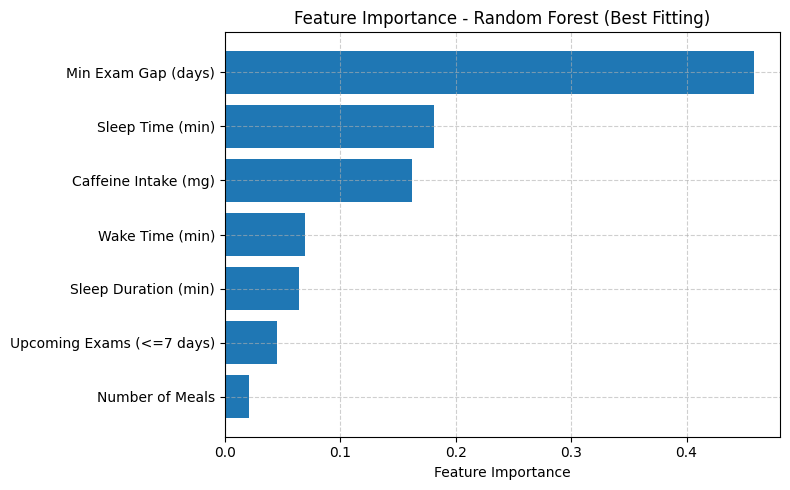

In [22]:
import matplotlib.pyplot as plt
import numpy as np

# Get feature importances from the trained Random Forest model
importances = rfg_default_model.feature_importances_
feature_names_tr = X.columns

# Create a dictionary to translate Turkish feature names to English
feature_translation = {
    'Uyuma Süresi (dakika)': 'Sleep Duration (min)',
    'Estimated Caffeine Intake (mg)': 'Caffeine Intake (mg)',
    'Günlük Öğün Sayısı': 'Number of Meals',
    'Active Exam Count (<=7 days)': 'Upcoming Exams (<=7 days)',
    'Min Exam Gap': 'Min Exam Gap (days)',
    'Sleep Time (min)': 'Sleep Time (min)',
    'Wake Time (min)': 'Wake Time (min)'
}

# Translate feature names
feature_names_en = [feature_translation.get(name, name) for name in feature_names_tr]

# Sort importances for plot
sorted_idx = np.argsort(importances)

# Plot horizontal bar chart
plt.figure(figsize=(8, 5))
plt.barh(range(len(importances)), importances[sorted_idx], align='center')
plt.yticks(range(len(importances)), [feature_names_en[i] for i in sorted_idx])
plt.xlabel("Feature Importance")
plt.title("Feature Importance - Random Forest (Best Fitting)")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


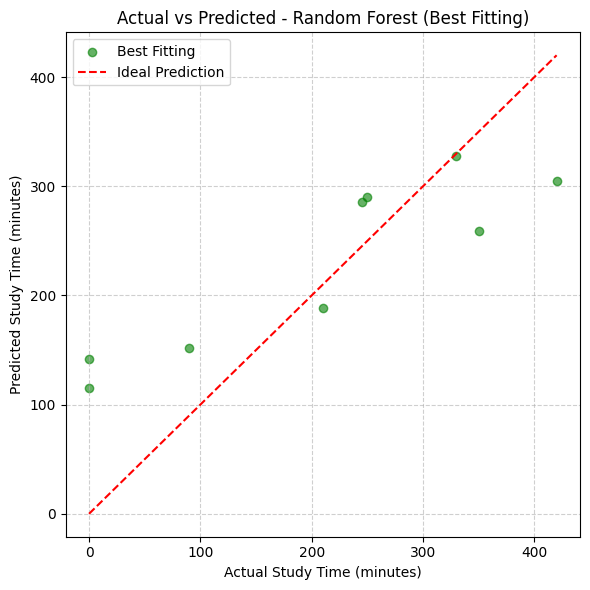

In [21]:
import matplotlib.pyplot as plt

# 📈 Actual vs Predicted scatter plot for Random Forest (Best Fitting)
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred_rfg_default, alpha=0.6, color='green', label='Best Fitting')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Ideal Prediction')
plt.xlabel("Actual Study Time (minutes)")
plt.ylabel("Predicted Study Time (minutes)")
plt.title("Actual vs Predicted - Random Forest (Best Fitting)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


# Supervised Learning: Regression Model


**Algorithm:**XGBoost Algorithm


**Aim:**Predict Study Hour

In [23]:
# Supervised Learning: Regression Model

# XGBoost Regressor Algorithm

#  Import Required Libraries
import pandas as pd
import numpy as np
import re
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor

#  Clean and normalize column names
df.columns = df.columns.str.strip().str.replace('\n', ' ').str.replace(r'\s+', ' ', regex=True)

#  Helper function: convert time (HH:MM:SS) to total minutes since midnight
def time_to_minutes(t):
    return t.hour * 60 + t.minute

#  Compute caffeine intake (assume 75 mg per coffee)
df['Estimated Caffeine Intake (mg)'] = pd.to_numeric(df['İçilen Kahve Miktarı'], errors='coerce').fillna(0).astype(int) * 75

#  Extract exam dates from text
exam_dates = set()
for entry in df['Ders Adı ve Sınavının Tarihleri'].dropna().astype(str):
    matches = re.findall(r'\d{2}\.\d{2}\.\d{4}', entry)
    for date_str in matches:
        try:
            exam_dates.add(pd.to_datetime(date_str, format='%d.%m.%Y'))
        except:
            continue
exam_dates = sorted(exam_dates)

#  Calculate days until each exam
def compute_exam_gaps(row):
    today = row['Tarih']
    gaps = [(exam - today).days for exam in exam_dates if (exam - today).days >= 0]
    return gaps

df['All Exam Gaps'] = df.apply(compute_exam_gaps, axis=1)
df['Min Exam Gap'] = df['All Exam Gaps'].apply(lambda x: min(x) if len(x) > 0 else 999)
df['Active Exam Count (<=7 days)'] = df['All Exam Gaps'].apply(lambda x: sum(1 for d in x if d <= 7))

# ⏰ Convert sleep/wake time to numeric
df['Sleep Time (min)'] = df['Uyuma Saati'].apply(time_to_minutes)
df['Wake Time (min)'] = df['Uyanma Saati'].apply(time_to_minutes)

#  Calculate sleep duration if not already calculated
def compute_sleep_duration(sleep_time, wake_time):
    sleep_dt = datetime.combine(datetime.today(), sleep_time)
    wake_dt = datetime.combine(datetime.today(), wake_time)
    if wake_dt <= sleep_dt:
        wake_dt += timedelta(days=1)
    return int((wake_dt - sleep_dt).total_seconds() / 60)

if 'Uyuma Süresi (dakika)' not in df.columns:
    df['Uyuma Süresi (dakika)'] = df.apply(
        lambda row: compute_sleep_duration(row['Uyuma Saati'], row['Uyanma Saati']),
        axis=1
    )

#  Ensure the target column is numeric
df['Ders Çalışma Süresi (dakika)'] = pd.to_numeric(df['Ders Çalışma Süresi (dakika)'], errors='coerce')

#  Define features and target
features = [
    'Uyuma Süresi (dakika)',                    # Sleep duration
    'Estimated Caffeine Intake (mg)',           # Caffeine
    'Günlük Öğün Sayısı',                       # Meal count
    'Active Exam Count (<=7 days)',             # Exams within 7 days
    'Min Exam Gap',                             # Days to next exam
    'Sleep Time (min)',                         # Bedtime
    'Wake Time (min)'                           # Wake time
]
target = 'Ders Çalışma Süresi (dakika)'         # Study time

X = df[features]
y = df[target]

# ✅ Clean feature names for XGBoost
X.columns = X.columns.str.replace('[\[\]<>]', '', regex=True)

#  Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#  Train XGBoost Regression model
xgb_model = XGBRegressor(random_state=42)
xgb_model.fit(X_train, y_train)

# 🔮 Make predictions
y_pred_xgb = xgb_model.predict(X_test)

#  Evaluate model
r2_xgb = r2_score(y_test, y_pred_xgb)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mse_xgb)

#  Print results
print("R² Score:", round(r2_xgb, 3))
print("RMSE:", round(rmse_xgb, 2), "minutes")


R² Score: 0.67
RMSE: 82.05 minutes


In [25]:
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

# Define parameter combinations to test
param_grid_xgb = [
    {'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 1.0},
    {'n_estimators': 200, 'max_depth': 4, 'learning_rate': 0.05, 'subsample': 0.9},
    {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.03, 'subsample': 0.8},
    {'n_estimators': 100, 'max_depth': 6, 'learning_rate': 0.2, 'subsample': 1.0},
    {'n_estimators': 200, 'max_depth': 6, 'learning_rate': 0.1, 'subsample': 0.7},
    {'n_estimators': 250, 'max_depth': 8, 'learning_rate': 0.02, 'subsample': 0.85}
]

print("🔍 XGBoost Hyperparameter Tuning Results:\n")

# Loop through each configuration
for params in param_grid_xgb:
    xgb = XGBRegressor(
        n_estimators=params['n_estimators'],
        max_depth=params['max_depth'],
        learning_rate=params['learning_rate'],
        subsample=params['subsample'],
        random_state=42,
        verbosity=0
    )
    xgb.fit(X_train, y_train)
    preds = xgb.predict(X_test)

    r2 = r2_score(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))

    print(f"n_estimators = {params['n_estimators']}, max_depth = {params['max_depth']}, "
          f"learning_rate = {params['learning_rate']}, subsample = {params['subsample']}")
    print(f"→ R² Score: {r2:.3f}, RMSE: {rmse:.2f} minutes\n")


🔍 XGBoost Hyperparameter Tuning Results:

n_estimators = 100, max_depth = 3, learning_rate = 0.1, subsample = 1.0
→ R² Score: 0.441, RMSE: 106.78 minutes

n_estimators = 200, max_depth = 4, learning_rate = 0.05, subsample = 0.9
→ R² Score: 0.580, RMSE: 92.52 minutes

n_estimators = 300, max_depth = 5, learning_rate = 0.03, subsample = 0.8
→ R² Score: 0.632, RMSE: 86.67 minutes

n_estimators = 100, max_depth = 6, learning_rate = 0.2, subsample = 1.0
→ R² Score: 0.712, RMSE: 76.68 minutes

n_estimators = 200, max_depth = 6, learning_rate = 0.1, subsample = 0.7
→ R² Score: 0.535, RMSE: 97.39 minutes

n_estimators = 250, max_depth = 8, learning_rate = 0.02, subsample = 0.85
→ R² Score: 0.682, RMSE: 80.57 minutes



### 📊 XGBoost Hyperparameter Tuning Summary

**n_estimators = 100, max_depth = 6, learning_rate = 0.2, subsample = 1.0**  
→ R² Score: 0.712  
→ RMSE: 76.68 minutes  
✅ Best performing configuration.

**n_estimators = 250, max_depth = 8, learning_rate = 0.02, subsample = 0.85**  
→ R² Score: 0.682  
→ RMSE: 80.57 minutes  
Strong performance with deeper trees and slower learning.

**n_estimators = 300, max_depth = 5, learning_rate = 0.03, subsample = 0.8**  
→ R² Score: 0.632  
→ RMSE: 86.67 minutes  
Moderately good, stable configuration.

**n_estimators = 200, max_depth = 4, learning_rate = 0.05, subsample = 0.9**  
→ R² Score: 0.580  
→ RMSE: 92.52 minutes  
Lower depth and slower learning yield moderate results.

**n_estimators = 200, max_depth = 6, learning_rate = 0.1, subsample = 0.7**  
→ R² Score: 0.535  
→ RMSE: 97.39 minutes  
Weaker results likely due to subsampling too aggressively.

**n_estimators = 100, max_depth = 3, learning_rate = 0.1, subsample = 1.0**  
→ R² Score: 0.441  
→ RMSE: 106.78 minutes  
Shallow trees underfit the data.


In [26]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Train the best-performing XGBoost model
xgb_best_model = XGBRegressor(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.2,
    subsample=1.0,
    random_state=42,
    verbosity=0
)

xgb_best_model.fit(X_train, y_train)
y_pred_xgb_best = xgb_best_model.predict(X_test)

# Evaluate the model
r2_xgb_best = r2_score(y_test, y_pred_xgb_best)
rmse_xgb_best = np.sqrt(mean_squared_error(y_test, y_pred_xgb_best))

print("R² Score:", round(r2_xgb_best, 3))
print("RMSE:", round(rmse_xgb_best, 2), "minutes")


R² Score: 0.712
RMSE: 76.68 minutes


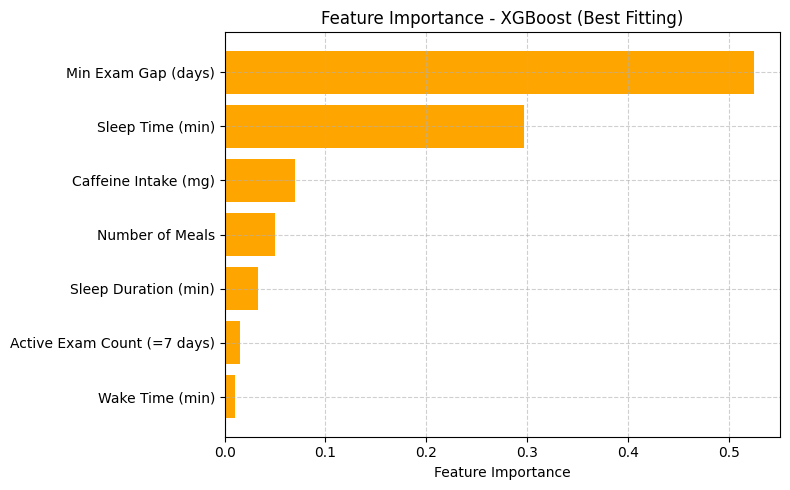

In [28]:
# Get feature importances
importances_xgb = xgb_best_model.feature_importances_
feature_names_tr = X.columns

# Translate Turkish to English
feature_translation = {
    'Uyuma Süresi (dakika)': 'Sleep Duration (min)',
    'Estimated Caffeine Intake (mg)': 'Caffeine Intake (mg)',
    'Günlük Öğün Sayısı': 'Number of Meals',
    'Active Exam Count (<=7 days)': 'Upcoming Exams (<=7 days)',
    'Min Exam Gap': 'Min Exam Gap (days)',
    'Sleep Time (min)': 'Sleep Time (min)',
    'Wake Time (min)': 'Wake Time (min)'
}
feature_names_en = [feature_translation.get(name, name) for name in feature_names_tr]

# Sort importances
sorted_idx = np.argsort(importances_xgb)

# Plot
plt.figure(figsize=(8, 5))
plt.barh(range(len(importances_xgb)), importances_xgb[sorted_idx], align='center', color='orange')
plt.yticks(range(len(importances_xgb)), [feature_names_en[i] for i in sorted_idx])
plt.xlabel("Feature Importance")
plt.title("Feature Importance - XGBoost (Best Fitting)")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


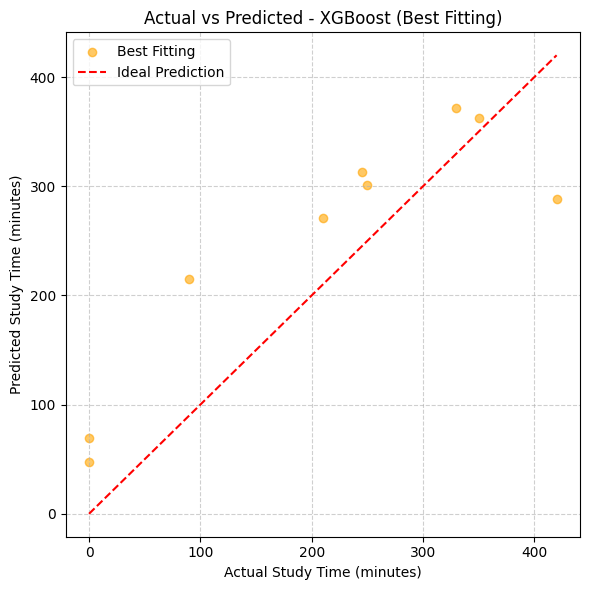

In [27]:
import matplotlib.pyplot as plt

# Actual vs Predicted Scatter Plot
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred_xgb_best, alpha=0.6, color='orange', label='Best Fitting')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Ideal Prediction')
plt.xlabel("Actual Study Time (minutes)")
plt.ylabel("Predicted Study Time (minutes)")
plt.title("Actual vs Predicted - XGBoost (Best Fitting)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


# Supervised Learning: Regression Model

**Algorithm:** K-Nearest Neighbors (KNN) Regressor

**Aim:** Predict Study Hour


In [29]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Initialize and train KNN Regressor
#Prediction for k=5
knn_model = KNeighborsRegressor(n_neighbors=5)
knn_model.fit(X_train, y_train)

# Predict
y_pred_knn = knn_model.predict(X_test)

# Evaluate
r2_knn = r2_score(y_test, y_pred_knn)
rmse_knn = np.sqrt(mean_squared_error(y_test, y_pred_knn))

# Results
print("R² Score (KNN):", round(r2_knn, 3))
print("RMSE (KNN):", round(rmse_knn, 2), "minutes")


R² Score (KNN): 0.525
RMSE (KNN): 98.39 minutes


In [31]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

# Define k values to test
k_values = [1, 3, 5, 7, 10, 15]

print("🔍 KNN Regressor Hyperparameter Tuning Results:\n")

# Loop through k values
for k in k_values:
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(X_train, y_train)
    preds = knn.predict(X_test)

    r2 = r2_score(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))

    print(f"n_neighbors = {k}")
    print(f"→ R² Score: {r2:.3f}, RMSE: {rmse:.2f} minutes\n")


🔍 KNN Regressor Hyperparameter Tuning Results:

n_neighbors = 1
→ R² Score: 0.022, RMSE: 141.24 minutes

n_neighbors = 3
→ R² Score: 0.557, RMSE: 95.09 minutes

n_neighbors = 5
→ R² Score: 0.525, RMSE: 98.39 minutes

n_neighbors = 7
→ R² Score: 0.409, RMSE: 109.80 minutes

n_neighbors = 10
→ R² Score: 0.403, RMSE: 110.31 minutes

n_neighbors = 15
→ R² Score: 0.442, RMSE: 106.69 minutes



### 📊 K-Nearest Neighbors (KNN) Hyperparameter Tuning Summary

**n_neighbors = 3**  
→ R² Score: 0.557  
→ RMSE: 95.09 minutes  
✅ Best performing value for K.

**n_neighbors = 5**  
→ R² Score: 0.525  
→ RMSE: 98.39 minutes  
Slightly weaker than k=3.

**n_neighbors = 15**  
→ R² Score: 0.442  
→ RMSE: 106.69 minutes  
Larger k leads to underfitting.

**n_neighbors = 7**  
→ R² Score: 0.409  
→ RMSE: 109.80 minutes  
Underfits the data.

**n_neighbors = 10**  
→ R² Score: 0.403  
→ RMSE: 110.31 minutes  
Same underfitting trend continues.

**n_neighbors = 1**  
→ R² Score: 0.022  
→ RMSE: 141.24 minutes  
Overfits badly to local noise.


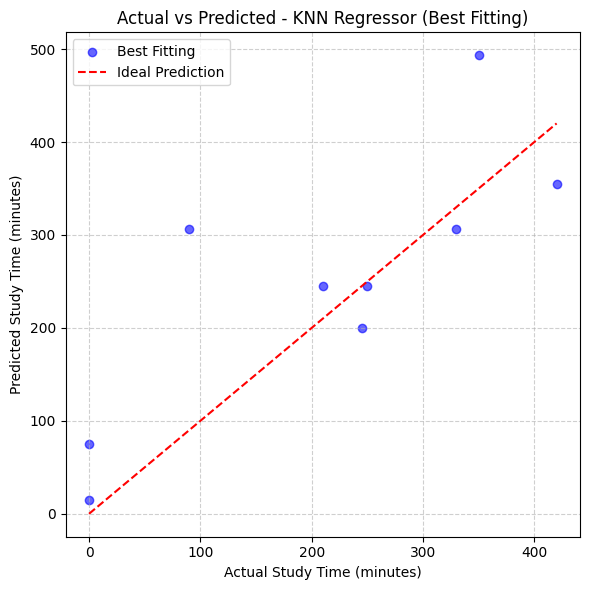

In [32]:
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsRegressor

#  Re-train KNN with best k = 3
knn_best_model = KNeighborsRegressor(n_neighbors=3)
knn_best_model.fit(X_train, y_train)
y_pred_knn_best = knn_best_model.predict(X_test)

#  Plot
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred_knn_best, alpha=0.6, color='blue', label='Best Fitting')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Ideal Prediction')
plt.xlabel("Actual Study Time (minutes)")
plt.ylabel("Predicted Study Time (minutes)")
plt.title("Actual vs Predicted - KNN Regressor (Best Fitting)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [34]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# 🎯 Best-performing Random Forest model (default params gave best results)
rfg_best_model = RandomForestRegressor(random_state=42)
rfg_best_model.fit(X_train, y_train)

# 🔮 Predict
y_pred_rfg_best = rfg_best_model.predict(X_test)

# 📊 Evaluate
r2_rfg_best = r2_score(y_test, y_pred_rfg_best)
rmse_rfg_best = np.sqrt(mean_squared_error(y_test, y_pred_rfg_best))

# 💬 Print results
print("R² Score (RFG):", round(r2_rfg_best, 3))
print("RMSE (RFG):", round(rmse_rfg_best, 2), "minutes")



R² Score (RFG): 0.659
RMSE (RFG): 83.36 minutes


In [36]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Train KNN with best k=3
knn_best_model = KNeighborsRegressor(n_neighbors=3)
knn_best_model.fit(X_train, y_train)

# Predict
y_pred_knn_best = knn_best_model.predict(X_test)

# Evaluate
r2_knn_best = r2_score(y_test, y_pred_knn_best)
rmse_knn_best = np.sqrt(mean_squared_error(y_test, y_pred_knn_best))

# Optional print
print("R² Score (KNN Best):", round(r2_knn_best, 3))
print("RMSE (KNN Best):", round(rmse_knn_best, 2), "minutes")


R² Score (KNN Best): 0.557
RMSE (KNN Best): 95.09 minutes


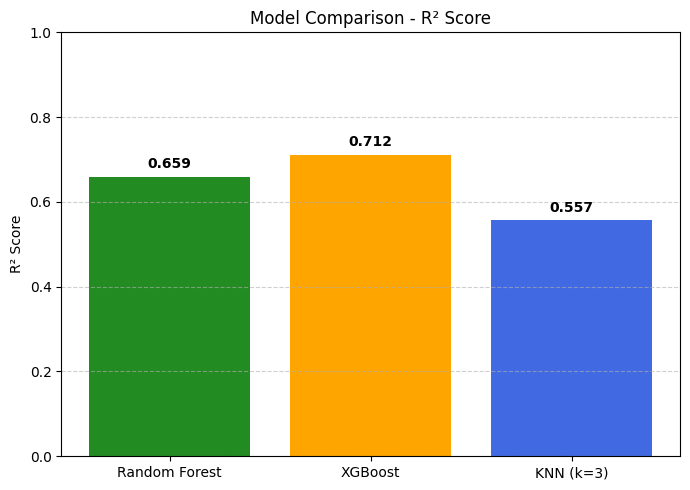

In [37]:
import matplotlib.pyplot as plt

# Models and dynamically computed R² scores
models = ['Random Forest', 'XGBoost', 'KNN (k=3)']
r2_scores = [r2_rfg_best, r2_xgb_best, r2_knn_best]

plt.figure(figsize=(7, 5))
plt.bar(models, r2_scores, color=['forestgreen', 'orange', 'royalblue'])
plt.ylabel("R² Score")
plt.title("Model Comparison - R² Score")
plt.ylim(0, 1)

for i, val in enumerate(r2_scores):
    plt.text(i, val + 0.02, f"{val:.3f}", ha='center', fontsize=10, fontweight='bold')

plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


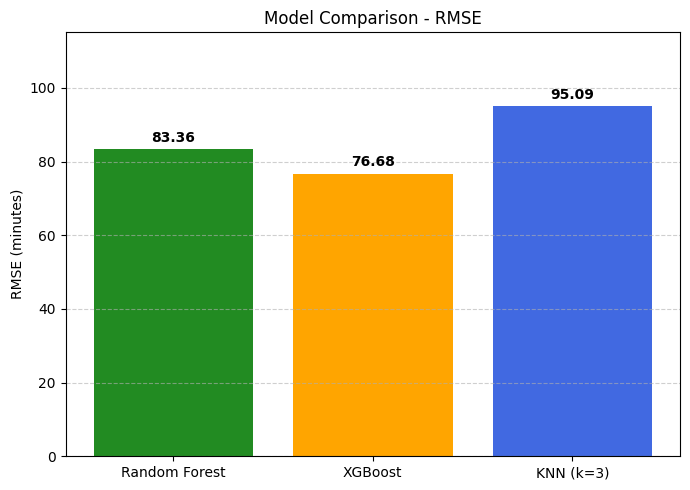

In [38]:
import matplotlib.pyplot as plt

# Define model names and their corresponding RMSE values
models = ['Random Forest', 'XGBoost', 'KNN (k=3)']
rmse_values = [rmse_rfg_best, rmse_xgb_best, rmse_knn_best]  # dynamically retrieved best values

# 📊 Create the bar chart
plt.figure(figsize=(7, 5))
plt.bar(models, rmse_values, color=['forestgreen', 'orange', 'royalblue'])

# 🏷️ Labeling the plot
plt.ylabel("RMSE (minutes)")
plt.title("Model Comparison - RMSE")
plt.ylim(0, max(rmse_values) + 20)

# 🔢 Annotate each bar with its RMSE value
for i, val in enumerate(rmse_values):
    plt.text(i, val + 2, f"{val:.2f}", ha='center', fontsize=10, fontweight='bold')

# 📐 Add gridlines for better readability
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


## 🧠 Comparison of Model Characteristics

### 🔧 Model Complexity & Interpretability

- 🟦 **KNN Regressor (k=3)**  
  → **Complexity**: Low  
  → **Interpretability**: High – intuitive and easy to explain (based on neighbor proximity)

- 🟩 **Random Forest Regressor**  
  → **Complexity**: Medium  
  → **Interpretability**: Medium – can output feature importance directly

- 🔷 **XGBoost Regressor**  
  → **Complexity**: High  
  → **Interpretability**: Lower – advanced structure, but explainable via SHAP values

---

### 💻 Training Time & Scalability

- 🟦 **KNN Regressor (k=3)**  
  → No training time, but **very slow** at prediction (distance calculations for each sample)

- 🟩 **Random Forest Regressor**  
  → Fast training and scalable through tree-level parallelization

- 🔷 **XGBoost Regressor**  
  → Slower training, but highly optimized and scalable (even supports GPU)

---

### 📊 Feature Importance Availability

- 🟩 **Random Forest** → ✅ Built-in  
- 🔷 **XGBoost** → ✅ Available via `gain`, `cover`, and **SHAP**  
- 🟦 **KNN** → ❌ Not available – non-parametric model

---

### ⚠️ Sensitivity to Noise & Outliers

- 🔷 **XGBoost** → Medium – might overfit if not regularized  
- 🟩 **Random Forest** → Low – robust due to ensembling  
- 🟦 **KNN** → High – easily affected by outliers and noisy points

---

### 🔮 Extrapolation & Generalization

- 🔷 **XGBoost** → Good generalization and ability to learn complex patterns  
- 🟩 **Random Forest** → Decent, but struggles with extrapolation beyond training data  
- 🟦 **KNN** → No extrapolation – only interpolates based on known instances

---

### ✅ Summary

- 🥇 **XGBoost Regressor** is the most powerful overall: strong accuracy, generalization, and scalability  
- 🥈 **Random Forest Regressor** offers a great balance of performance and interpretability  
- ⚠️ **KNN Regressor** is simple and useful for small datasets, but not ideal for high-variance or large-scale data


## 📊 Comparison of Regression Models (Best Results)

### 🔷 XGBoost Regressor  
- **R² Score**: 0.712 → Best explained variance  
- **RMSE**: 76.68 minutes → Lowest prediction error ✅

### 🟩 Random Forest Regressor  
- **R² Score**: 0.659 → Strong explanation of variance  
- **RMSE**: 83.36 minutes → Slightly higher error

### 🟦 KNN Regressor (k = 3)  
- **R² Score**: 0.557 → Less variance explained  
- **RMSE**: 95.09 minutes → Highest prediction error ⚠️

---

### 📌 Summary
- ✅ **XGBoost** showed the best overall performance in both accuracy and variance explanation.  
- ✅ **Random Forest** also performed consistently and is a solid alternative.  
- ⚠️ **KNN**, while simple, did not perform as well on this dataset due to its non-parametric nature.

---

### 📘 Interpretation Notes
- **R² Score**: Indicates how much of the variation in study time is explained by the model.  
  → Higher is better.  
- **RMSE**: Average difference between predicted and actual study time.  
  → Lower is better.



### Final Notes About The Codes

- The data is collected by Ertuğrul Soydal.  
- The designs and test parameters are decided by Ertuğrul Soydal.  
- Using appropriate test methods and interpreting the results are also done by Ertuğrul Soydal.  
- In the visualization and hypothesis testing part, ChatGPT assistance was used to make the visualizations clearer and the test results more understandable.  
- This explanation is included to avoid any potential academic dishonesty.
